In [1]:
%matplotlib inline

2018-04-17 11:44:27,482 - pynamics.system - INFO - getting dynamic equations
2018-04-17 11:44:27,634 - pynamics.system - INFO - solving a = f/m and creating function
2018-04-17 11:44:27,924 - pynamics.system - INFO - done solving a = f/m and creating function
2018-04-17 11:44:28,065 - pynamics.integration - INFO - beginning integration
2018-04-17 11:44:28,067 - pynamics.system - INFO - integration at time 0000.00
2018-04-17 11:44:28,937 - pynamics.system - INFO - integration at time 0003.75
2018-04-17 11:44:29,168 - pynamics.integration - INFO - finished integration
2018-04-17 11:44:29,204 - pynamics.output - INFO - calculating outputs
2018-04-17 11:44:29,215 - pynamics.output - INFO - done calculating outputs
2018-04-17 11:44:29,356 - pynamics.output - INFO - calculating outputs
2018-04-17 11:44:29,364 - pynamics.output - INFO - done calculating outputs


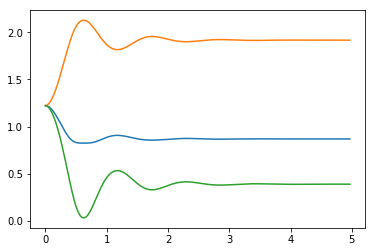

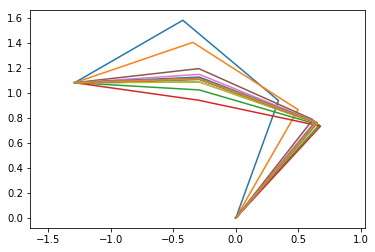

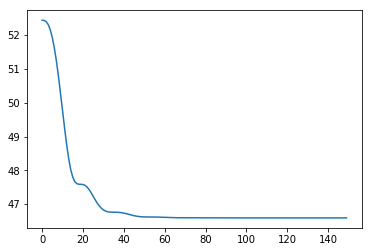

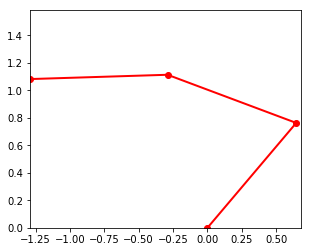

In [2]:
# -*- coding: utf-8 -*-
"""
Written by Daniel M. Aukes
Email: danaukes<at>gmail.com
Please see LICENSE for full license.
"""

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration

#import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
system = System()

global_q = False

lA = Constant(1,'lA',system)
lB = Constant(1,'lB',system)
lC = Constant(1,'lC',system)

mA = Constant(1,'mA',system)
mB = Constant(1,'mB',system)
mC = Constant(1,'mC',system)

g = Constant(9.81,'g',system)
b = Constant(1e0,'b',system)
k = Constant(1e1,'k',system)

tinitial = 0
tfinal = 5
tstep = 1/30
t = numpy.r_[tinitial:tfinal:tstep]

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)

Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)

qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

initialvalues = {}
initialvalues[qA]=70*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=70*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=70*pi/180
initialvalues[qC_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')

system.set_newtonian(N)
if not global_q:
    A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
    B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
    C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)
else:
    A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
    B.rotate_fixed_axis_directed(N,[0,0,1],qB,system)
    C.rotate_fixed_axis_directed(N,[0,0,1],qC,system)

pNA=0*N.x
pAB=pNA+lA*A.x
pBC = pAB + lB*B.x
pCtip = pBC + lC*C.x

pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x

wNA = N.getw_(A)
wAB = A.getw_(B)
wBC = B.getw_(C)

IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
#BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyC = Particle(pCcm,mC,'ParticleC',system)

system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)

if not global_q:
    system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
    system.add_spring_force1(k,(qB-preload2)*N.z,wAB)
    system.add_spring_force1(k,(qC-preload3)*N.z,wBC)
else:
    system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
    system.add_spring_force1(k,(qB-qA-preload2)*N.z,wAB)
    system.add_spring_force1(k,(qC-qB-preload3)*N.z,wBC)

system.addforcegravity(-g*N.y)

vCtip = pCtip.time_derivative(N,system)
eq = []
eq.append(pCtip.dot(N.x))
eq.append(pCtip.dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]


f,ma = system.getdynamics()
#func1 = system.state_space_post_invert(f,ma)
func1 = system.state_space_post_invert(f,ma,eq_dd)
states=pynamics.integration.integrate_odeint(func1,ini,t,rtol=1e-12,atol=1e-12,hmin=1e-14, args=({'constants':system.constant_values},))

KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()

points = [pNA,pAB,pBC,pCtip]
#points = [item for item2 in points for item in [item2.dot(system.newtonian.x),item2.dot(system.newtonian.y)]]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
#y.resize(y.shape[0],int(y.shape[1]/2),2)

plt.figure()
plt.plot(t,states[:,:3])

plt.figure()
plt.plot(*(y[::int(len(y)/20)].T))
plt.axis('equal')

energy_output = Output([KE-PE],system)
energy_output.calc(states)

plt.figure()
plt.plot(energy_output.y)

#points_output.make_gif()
#points_output.render_movie()
points_output.animate(fps = 30,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
#a()


In [3]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())